In [4]:
from torch.utils.data import Dataset, DataLoader

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from dataset import PineappleDataset
from VAE import VAE

In [16]:
test_set = PineappleDataset(train=False, train_ratio=0.8, path="../FULL_VERTICAL_PINEAPPLE/FULL_UNIFIED")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)

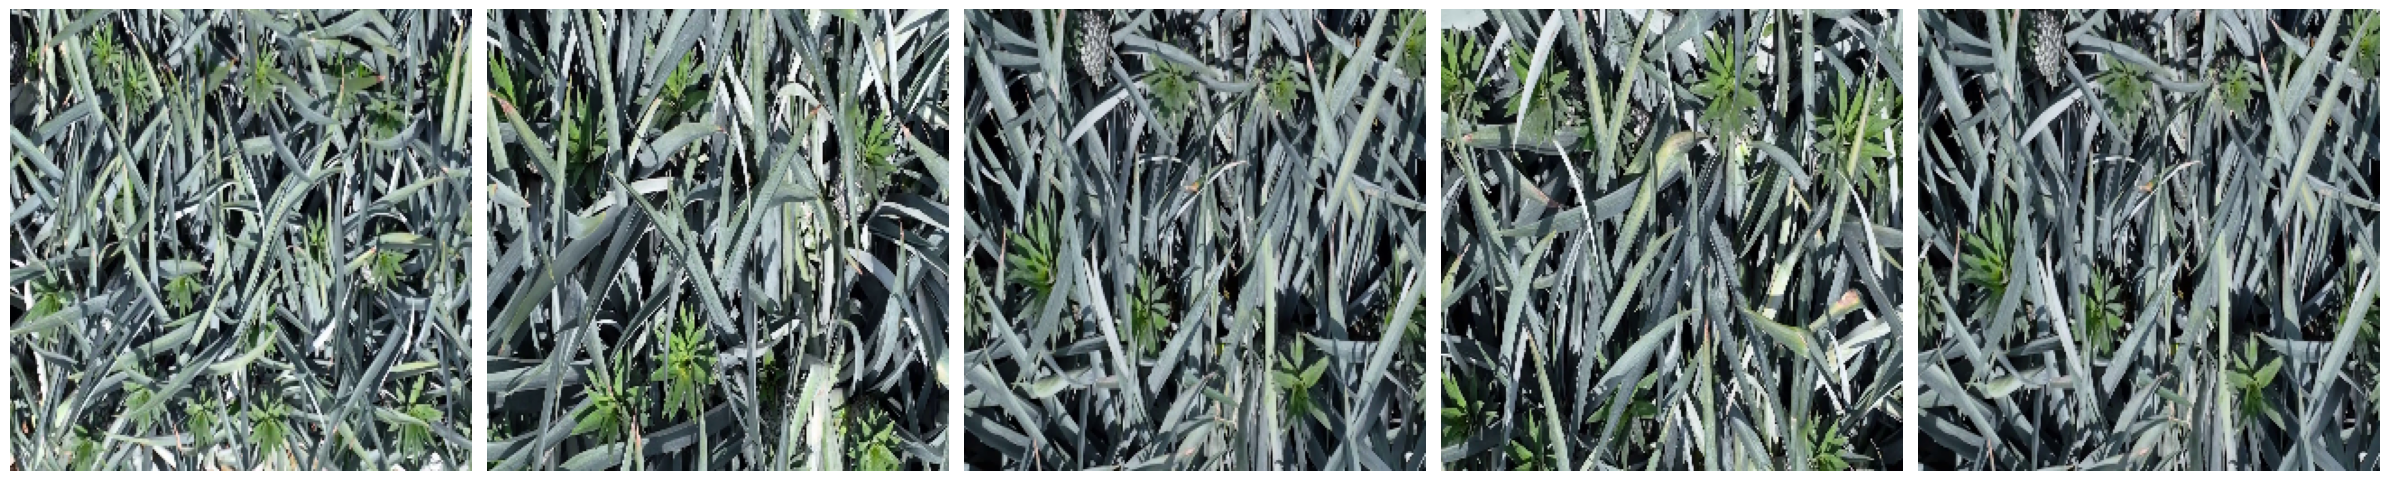

In [8]:
fig = plt.figure(figsize=(24, 6))  # Wider and shorter for horizontal layout
rows = 1
columns = 5

for i in range(columns):
    batch = test_set[np.random.randint(len(test_set))]
    img = batch['image'].transpose((1, 2, 0))  # Convert CHW to HWC
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
    plt.axis('off')  # Hide axis for better presentation

plt.tight_layout()
plt.show()

In [6]:
model = VAE()
checkpoint_path = "/home/rtxmsi1/Downloads/VAE_training-master/checkpoints/vae/betaKL@0.1/weights_ck_0.pt"  # Replace with your checkpoint file
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.eval()
model.cuda()  # Move model to GPU if available

VAE(
  (encoder): VAE_Encoder(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): VAE_ResidualBlock(
      (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (groupnorm_2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (residual_layer): Identity()
    )
    (2): VAE_ResidualBlock(
      (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (groupnorm_2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (residual_layer): Identity()
    )
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (4): VAE_ResidualBlock(
      (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv

In [ ]:
for module in model.named_modules():
    print(module)

('', VAE(
  (encoder): VAE_Encoder(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): VAE_ResidualBlock(
      (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (groupnorm_2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (residual_layer): Identity()
    )
    (2): VAE_ResidualBlock(
      (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (groupnorm_2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (residual_layer): Identity()
    )
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (4): VAE_ResidualBlock(
      (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      

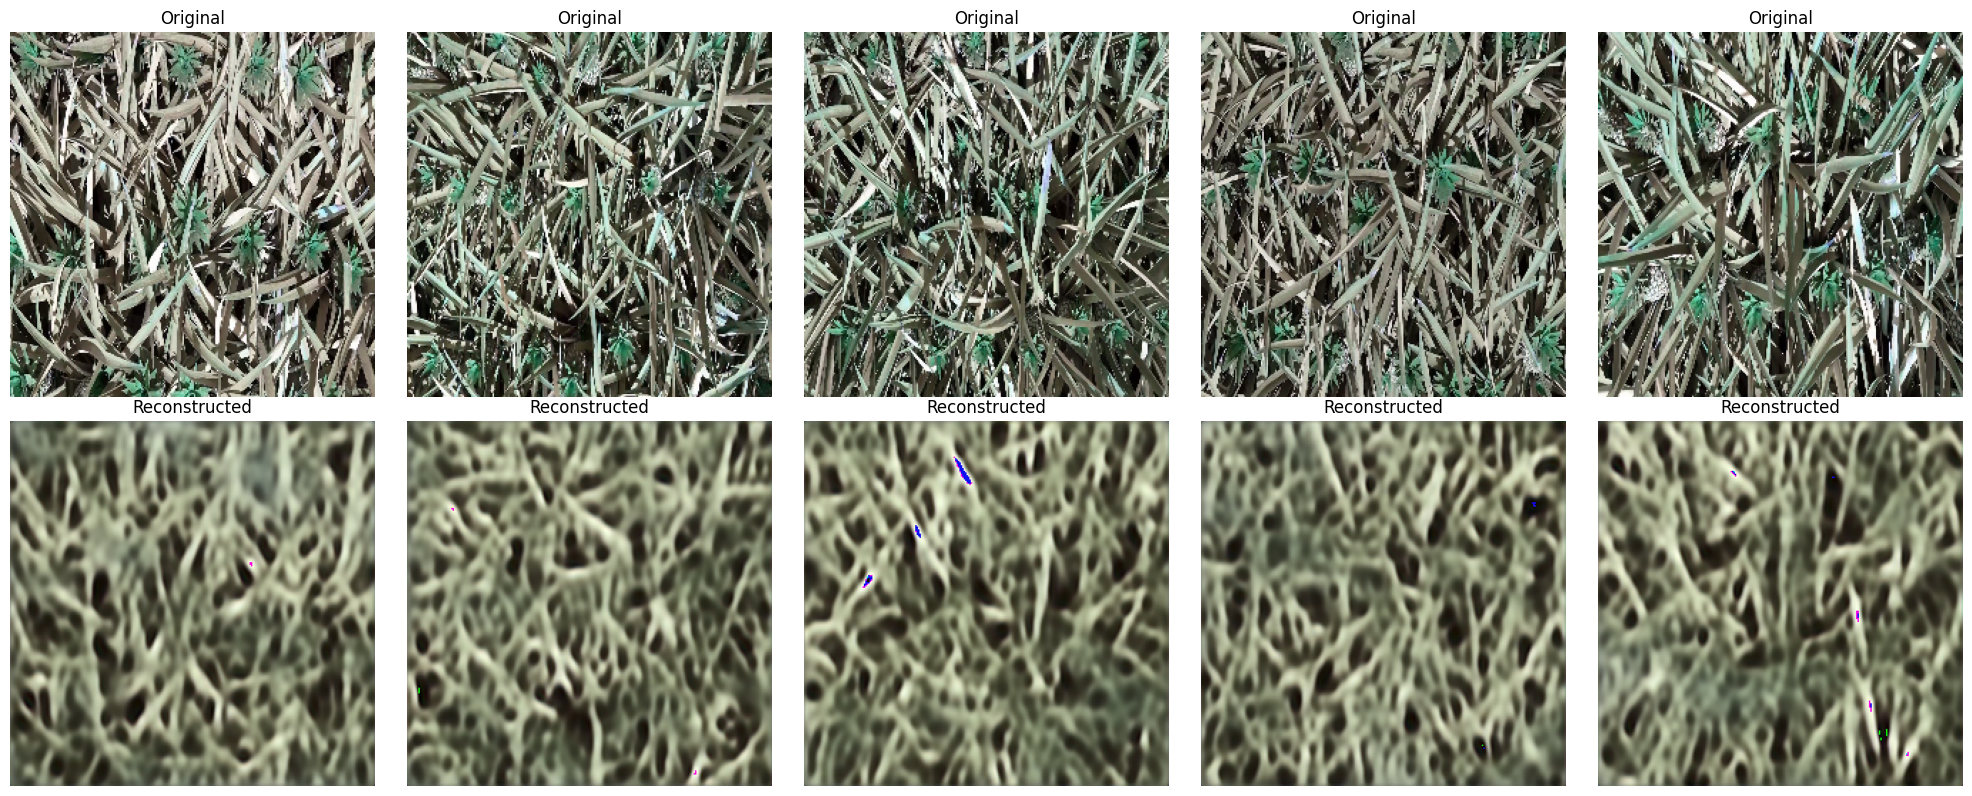

In [9]:
fig = plt.figure(figsize=(20, 8))  # Wide figure
rows, columns = 2, 5  # 2 rows (original + reconstructed), 5 columns

for i in range(columns):
    index = np.random.randint(len(test_set))

    # Get original image
    original_image = test_set[index]['image']
    input_tensor = torch.tensor(original_image).unsqueeze(0).cuda()

    # Model inference
    with torch.no_grad():
        reconstructed_image, _, _ = model(input_tensor)
    
    # Preprocess images for display
    original_image_disp = (original_image.transpose((1, 2, 0)) * 255).astype(np.uint8)
    reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()
    reconstructed_image_disp = (np.transpose(reconstructed_image, (1, 2, 0)) * 255).astype(np.uint8)

    # Plot original
    fig.add_subplot(rows, columns, i + 1, title='Original')
    plt.imshow(original_image_disp)
    plt.axis('off')

    # Plot reconstructed
    fig.add_subplot(rows, columns, i + 1 + columns, title='Reconstructed')
    plt.imshow(reconstructed_image_disp)
    plt.axis('off')

plt.tight_layout()
plt.show()

## GradCam

In [23]:
from collections import OrderedDict

class PropBase(object):

    def __init__(self, model, target_layer, cuda=True):
        self.model = model
        self.cuda = cuda
        if self.cuda:
            self.model.cuda()
        self.model.eval()
        self.target_layer = target_layer
        self.outputs_backward = OrderedDict()
        self.outputs_forward = OrderedDict()
        self.set_hook_func()

    def set_hook_func(self):
        raise NotImplementedError

    # set the target class as one others as zero. use this vector for back prop added by Lezi
    def encode_one_hot_batch(self, z, mu, logvar, mu_avg, logvar_avg):
        one_hot_batch = torch.FloatTensor(z.size()).zero_()
        return mu

    def forward(self, x):
        self.preds = self.model(x)
        self.image_size = x.size(-1)
        recon_batch, self.mu, self.logvar = self.model(x)
        return recon_batch, self.mu, self.logvar

    # back prop the one_hot signal
    def backward(self, mu, logvar, mu_avg, logvar_avg, z):
        self.model.zero_grad()
        #z = self.model.encoder(mu, logvar).cuda()
        one_hot = self.encode_one_hot_batch(z, mu, logvar, mu_avg, logvar_avg)

        if self.cuda:
            one_hot = one_hot.cuda()
        flag = 2
        if flag == 1:
            self.score_fc = torch.sum(F.relu(one_hot * mu))
        else:
            self.score_fc = torch.sum(one_hot)
        self.score_fc.backward(retain_graph=True)

    def get_conv_outputs(self, outputs, target_layer):
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        return value
        raise ValueError('invalid layer name: {}'.format(target_layer))


In [24]:
import torch.nn as nn
from torch.nn import functional as F

class GradCAM(PropBase):

    def set_hook_func(self):
        def func_b(module, grad_in, grad_out):
            self.outputs_backward[id(module)] = grad_out[0].cpu()

        def func_f(module, input, f_output):
            self.outputs_forward[id(module)] = f_output

        for module in self.model.named_modules():
            module[1].register_backward_hook(func_b)
            module[1].register_forward_hook(func_f)

    def normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm.item()

    def compute_gradient_weights(self):
        self.grads = self.normalize(self.grads.squeeze())
        self.map_size = self.grads.size()[2:]
        self.weights = nn.AvgPool2d(self.map_size)(self.grads)

    def generate(self):
        # get gradient
        self.grads = self.get_conv_outputs(
            self.outputs_backward, self.target_layer)
        # compute weithts based on the gradient
        self.compute_gradient_weights()

        # get activation
        self.activiation = self.get_conv_outputs(
            self.outputs_forward, self.target_layer)

        self.weights.volatile = False
        self.activiation = self.activiation[None, :, :, :, :]
        self.weights = self.weights[:, None, :, :, :]
        gcam = F.conv3d(self.activiation, (self.weights.cuda()), padding=0, groups=len(self.weights))
        gcam = gcam.squeeze(dim=0)
        gcam = F.upsample(gcam, (self.image_size, self.image_size), mode="bilinear")
        gcam = torch.abs(gcam)

        return gcam

In [25]:
def save_cam(image, filename, gcam):
    gcam = gcam - np.min(gcam)
    gcam = gcam / np.max(gcam)
    h, w, d = image.shape
    gcam = cv2.resize(gcam, (w, h))
    gcam = cv2.applyColorMap(np.uint8(255 * gcam), cv2.COLORMAP_JET)
    gcam = np.asarray(gcam, dtype=np.float) + \
        np.asarray(image, dtype=np.float)
    gcam = 255 * gcam / np.max(gcam)
    gcam = np.uint8(gcam)
    cv2.imwrite(filename, gcam)

In [26]:
gcam = GradCAM(model, target_layer='encoder.1.conv_1', cuda=True)

mu_avg, logvar_avg = 0, 1

for i, data in enumerate(test_loader):
    color_images = data["image"].cuda()

    batch_size, _, height, width = color_images.shape
    noise = torch.randn((batch_size, 4, height // 8, width // 8), device=color_images.device)

    z, _, _ = model.encoder(color_images, noise)
    
    recon, mu, logvar = gcam.forward(color_images)
    model.zero_grad()
    gcam.backward(mu, logvar, mu_avg, logvar_avg, z)
    gcam_map = gcam.generate() 

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 23.63 GiB of which 49.94 MiB is free. Including non-PyTorch memory, this process has 11.58 GiB memory in use. Process 9917 has 11.36 GiB memory in use. Of the allocated memory 11.01 GiB is allocated by PyTorch, and 127.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Latent Space 

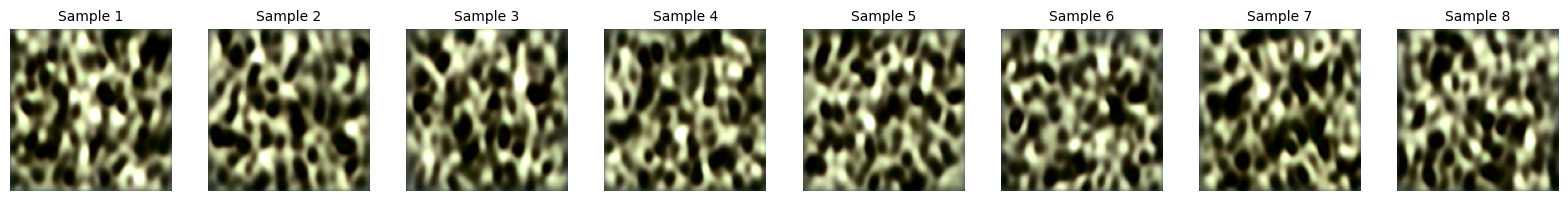

In [10]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Parameters
batch_size = 8
height, width = 128, 128
latent_channels = 4
latent_height, latent_width = height // 8, width // 8

# Sample latent space from N(0, 1)
latent = torch.randn(batch_size, latent_channels, latent_height, latent_width, device='cuda')

# Decode the latent vectors
decoder = model.decoder
reconstructed_images = decoder(latent).detach().cpu().clamp(0, 1)

# Plot the reconstructed images
n_images = min(batch_size, 8)
fig, axes = plt.subplots(1, n_images, figsize=(2 * n_images, 2))

for i in range(n_images):
    img = reconstructed_images[i].permute(1, 2, 0)  # Convert from CHW to HWC
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i+1}", fontsize=10)

plt.tight_layout()
plt.show()